In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data
from torchvision import datasets, transforms
# from torchvision.utils import save_image

from vae_conv import CVAE_model 

import sys, os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
class conv_variational_autoencoder(object): 
    '''
    variational autoencoder class 

    parameters:
      - image_size: tuple
        height and width of images
      - input_channels: int
        number of channels in input images
      - num_conv_layers: int 
        number of encoding/decoding convolutional layers
      - feature_map_list: list of ints
        number of output feature maps for each convolutional layer
      - filter_shape_list: list of tuples;
        convolutional filter shape for each convolutional layer
      - stride_list: list of tuples
        convolutional stride for each convolutional layer
      - num_dense_layers: int
        number of encoding/decoding dense layers
      - dense_neuron_list: list of ints
        number of neurons for each dense layer
      - dense_dropout_list: list of float
        fraction of neurons to drop in each dense layer (between 0 and 1)
      - latent_dim: int
        number of dimensions for latent embedding
      - activation: string (default='relu') 
        activation function to use for layers
      - eps_mean: float (default = 0.0) 
        mean to use for epsilon (target distribution for embedding);
      - eps_std: float (default = 1.0) 
        standard dev to use for epsilon (target distribution for embedding)
       
    methods:
      - train(data,batch_size,epochs=1,checkpoint=False,filepath=None)
        train network on given data
      - save(filepath)
        save the model weights to a file
      - load(filepath)
        load model weights from a file
      - return_embeddings(data)
        return the embeddings for given data
      - decode(embedding)
        return a generated output given a latent embedding 
      - predict(data) 
        return the predicted result of data
    '''
    def __init__(self, image_size, input_channel, 
                num_conv_layers, feature_map_list, filter_shape_list, stride_list, 
                num_dense_layers, dense_neuron_list, dense_dropout_list, latent_dim,
                activation_func='relu',
                eps_mean=0.0,eps_std=1.0):   
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CVAE_model(image_size, input_channel, 
                          num_conv_layers, feature_map_list, filter_shape_list, stride_list, 
                          num_dense_layers, dense_neuron_list, dense_dropout_list, latent_dim, 
                          activation_func='relu', eps_mean=0.0,eps_std=1.0).to(self.device)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.001, alpha=0.9, eps=1e-08, weight_decay=0)
        
        
    def encode(self, x): 
        return self.model.encode(x) 
    
    def reparameterize(self, mu, logvar): 
        return self.model.reparameterize(mu, logvar)
    
    def decode(self, z): 
        return self.model.decode(z) 
    
    def return_embeddings(self, x): 
        return self.model.reparameterize(*(self.model.encode(x))) 
    
    def predict(self, x): 
        return self.model(x)[0] 
    
    def train(self, data, epoch):  
        pass 
    


In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)   

In [4]:
channels = 1
# batch_size = cm_train.shape[0]/100
conv_layers = 4
feature_maps = [64,64,64,64]
filter_shapes = [3,3,3,3]
strides = [1,2,1,1]
dense_layers = 2
dense_neurons = [128, 64]
dense_dropouts = [0, 0]
latent_dim = 3
epochs = 1
image_size = 36

image_size = train_loader.dataset.train_data.shape[1]

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [5]:
autoencoder = conv_variational_autoencoder(image_size,channels,conv_layers,feature_maps,
                                           filter_shapes,strides,dense_layers,dense_neurons,dense_dropouts,latent_dim)

In [6]:
for i in autoencoder.model.state_dict(): 
    print i

encode_conv_layers.0.weight
encode_conv_layers.0.bias
encode_conv_layers.1.weight
encode_conv_layers.1.bias
encode_conv_layers.2.weight
encode_conv_layers.2.bias
encode_conv_layers.3.weight
encode_conv_layers.3.bias
encode_dense_layers.0.weight
encode_dense_layers.0.bias
encode_dense_layers.1.weight
encode_dense_layers.1.bias
latent_mu.weight
latent_mu.bias
latent_logvar.weight
latent_logvar.bias
latent_decode.weight
latent_decode.bias
decode_dense_layers.0.weight
decode_dense_layers.0.bias
decode_dense_layers.1.weight
decode_dense_layers.1.bias
decode_conv_layers.0.weight
decode_conv_layers.0.bias
decode_conv_layers.1.weight
decode_conv_layers.1.bias
decode_conv_layers.2.weight
decode_conv_layers.2.bias
decode_conv_layers.3.weight
decode_conv_layers.3.bias


In [7]:
log_interval = 100

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE_loss_func = nn.BCELoss(reduction='sum') 
    BCE = BCE_loss_func(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return BCE + KLD


def train(autoencoder, epoch):
    autoencoder.model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        autoencoder.optimizer.zero_grad()
        recon_batch, mu, logvar = autoencoder.model(data)
#         print(recon_batch.shape, data.shape)
        loss = loss_function(recon_batch, data, mu, logvar) 
        loss.backward()
        train_loss += loss.item()
        autoencoder.optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset))) 
    
    
def test(autoencoder, epoch):
    autoencoder.model.train()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = autoencoder.model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
epochs = 3
log_interval = 100
for epoch in range(1, epochs + 1):
    train(autoencoder, epoch) 
    test(autoencoder, epoch) 

Train Epoch: 1 [0/60000 (0%)]	Loss: 649.902161
Train Epoch: 1 [6400/60000 (11%)]	Loss: 222.806824
Train Epoch: 1 [12800/60000 (21%)]	Loss: 168.995682
Train Epoch: 1 [19200/60000 (32%)]	Loss: 162.849548
Train Epoch: 1 [25600/60000 (43%)]	Loss: 148.074799
Train Epoch: 1 [32000/60000 (53%)]	Loss: 146.023590
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.804077
Train Epoch: 1 [44800/60000 (75%)]	Loss: 139.017395
Train Epoch: 1 [51200/60000 (85%)]	Loss: 143.456573
Train Epoch: 1 [57600/60000 (96%)]	Loss: 151.274933
====> Epoch: 1 Average loss: 166.0708
====> Test set loss: 141.2000
Train Epoch: 2 [0/60000 (0%)]	Loss: 148.999420
Train Epoch: 2 [6400/60000 (11%)]	Loss: 157.381577
Train Epoch: 2 [12800/60000 (21%)]	Loss: 142.047913
Train Epoch: 2 [19200/60000 (32%)]	Loss: 134.277695
Train Epoch: 2 [25600/60000 (43%)]	Loss: 142.907364
Train Epoch: 2 [32000/60000 (53%)]	Loss: 134.304886
Train Epoch: 2 [38400/60000 (64%)]	Loss: 149.851364
Train Epoch: 2 [44800/60000 (75%)]	Loss: 136.579041
Train Ep

In [12]:
with torch.no_grad(): 
    train_all = train_loader.dataset.train_data.reshape(-1, 1, 28, 28).float()[:2000].to(device)
    print(train_all.shape)
    decoded = autoencoder.predict(train_all) 
    embeded = autoencoder.return_embeddings(train_all)

torch.Size([2000, 1, 28, 28])


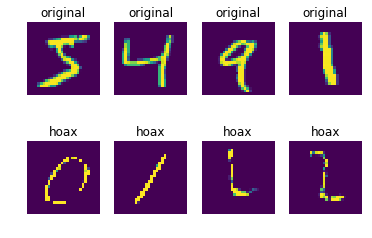

In [14]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(nrows=2, ncols=4) 

for i in range(4): 
    ax[0,i].imshow(np.squeeze(train_all.cpu())[2*i]) 
    ax[0,i].set_title('original')
    ax[1,i].imshow(np.squeeze(decoded.cpu())[2*i+1]) 
    ax[1,i].set_title('hoax')
    ax[0,i].axis('off') 
    ax[1,i].axis('off')
plt.show()

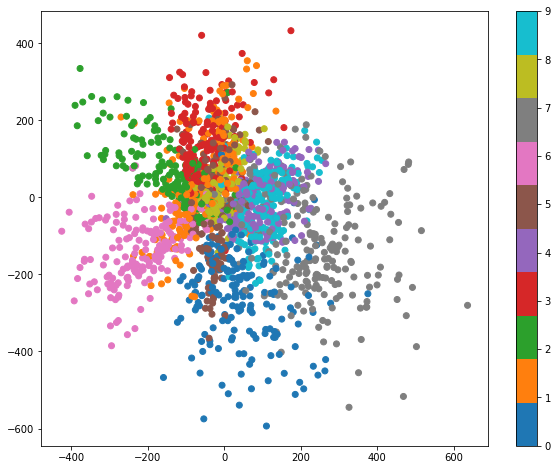

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(embeded.cpu()[:2000,0], embeded.cpu()[:2000,1], c=train_loader.dataset.train_labels.cpu()[:2000], cmap='tab10')
plt.colorbar()